# Alan Donahue Ch 10 Exercise

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

In [2]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

In [3]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

In [7]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

In [10]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

In [14]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

In [16]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

In [17]:
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

In [19]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [24]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

In [26]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

In [31]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

In [37]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

# Exercises

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [74]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [75]:
inter, slope = LeastSquares(heights, log_weights)
inter, slope

(0.9930804163918104, 0.005281454169417819)

Make a scatter plot of the data and show the fitted line.

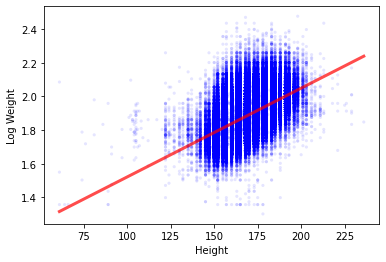

In [76]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

fit_xs, fit_ys = FitLine(heights, inter, slope)

thinkplot.Scatter(heights, log_weights, color = "blue", alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color = "red")
thinkplot.Config(xlabel = "Height", ylabel = "Log Weight")

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

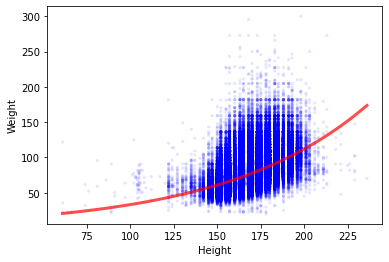

In [77]:
fit_xs, fit_ys = FitLine(heights, inter, slope)

thinkplot.Scatter(heights, weights, color = "blue", alpha = 0.1, s = 10)
thinkplot.Plot(fit_xs, 10**fit_ys, color = "red")
thinkplot.Config(xlabel = "Height", ylabel = "Weight")

Plot percentiles of the residuals.

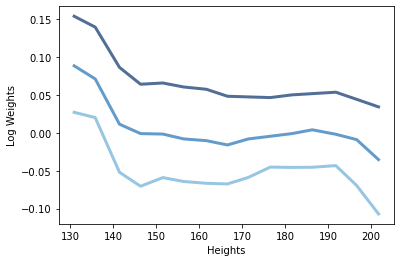

In [49]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)
        
df["residual"] = Residuals(heights, log_weights, inter, slope)

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

PlotPercentiles(means, cdfs)
thinkplot.Config(xlabel = "Heights", ylabel = "Residual Weights")


Compute correlation.

In [51]:
correlation = thinkstats2.Corr(heights, log_weights)
correlation

0.5317282605983443

Compute coefficient of determination.

In [54]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

r2 = CoefDetermination(log_weights, df.residual)
r2

0.28273494311894065

Confirm that $R^2 = \rho^2$.

In [56]:
print(correlation)
print(np.sqrt(r2))

0.5317282605983443
0.5317282605983442


Compute Std(ys), which is the RMSE of predictions that don't use height.

In [61]:
std_ys = thinkstats2.Std(log_weights)
print('Std(ys)', std_ys)

Std(ys) 0.103207250300049


Compute Std(res), the RMSE of predictions that do use height.

In [62]:
std_res = thinkstats2.Std(df.residual)
print('Std(res)', std_res)

Std(res) 0.0874077708041609


How much does height information reduce RMSE?

In [63]:
1 - std_res / std_ys

0.15308497658793452

Use resampling to compute sampling distributions for inter and slope.

In [64]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

t = []
for i in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

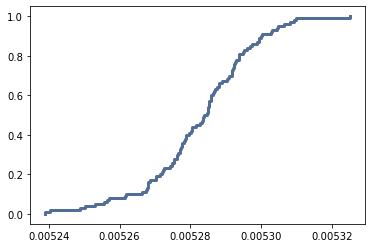

In [65]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [66]:
pvalue = cdf[0]
pvalue

0

Compute the 90% confidence interval of slope.

In [67]:
confidence_interval = cdf.Percentile(5), cdf.Percentile(95)
confidence_interval

(0.0052530762075964025, 0.005304820173041405)

Compute the mean of the sampling distribution.

In [69]:
mean = thinkstats2.Mean(slopes)
mean

0.005282580531252245

Compute the standard deviation of the sampling distribution, which is the standard error.

In [70]:
standard_deviation = thinkstats2.Std(slopes)
standard_deviation

1.5090966533228144e-05

Resample rows without weights, compute mean height, and summarize results.

In [72]:
resample_wo_weights = [ResampleRows(df).htm3.mean() for i in range(100)]
Summarize(resample_wo_weights)

mean, SE, CI 168.95689219163688 0.017167600843676935 (168.9297227106449, 168.98279825784675)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [73]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

resample_weighted = [ResampleRowsWeighted(df, "finalwt").htm3.mean() for i in range(100)]
Summarize(resample_weighted)

mean, SE, CI 170.495492077447 0.014807422413439695 (170.47301885648457, 170.51811374522524)
